In [1]:
%load_ext autoreload
%autoreload 2

import torch
import notebook_setup

device = torch.device('cpu')

/home/brendan/anaconda3/envs/impl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

Define data distribution and take a sample

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from callbacks import UpdateProgressBarStats
from implicit.datasets import VonMisesMixture
from visualization import plot_2d_points

dist = VonMisesMixture() # Set data distribution here

points = torch.cat(dist.manifold_points())
densities = dist.prob(points)
data = dist.sample(1000)

lims = {"xlims": (-3.3, 3.3), "ylims": (-1.5, 1.5)} # Set x and y lims for each plot
lims3d = {"xlims": (-3.3, 3.3), "ylims": (-3.3, 3.3)}
ebm_lims = torch.Tensor(((-3.3, -3.3), (3.3, 3.3)))

dataloader = data.split(100)
callbacks = [UpdateProgressBarStats(loader=dataloader)]

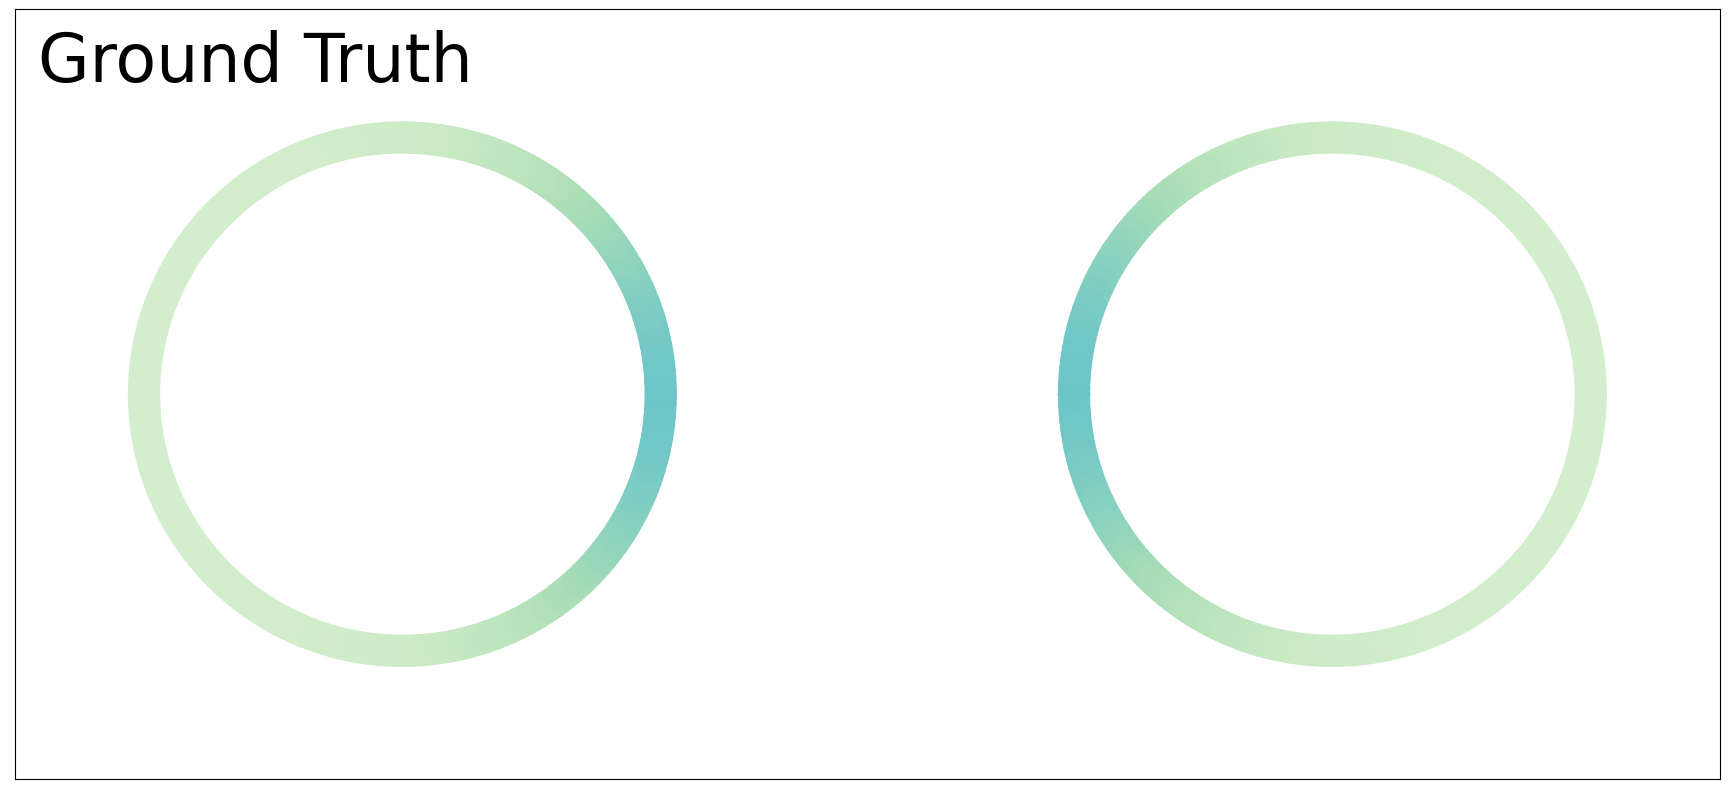

In [3]:
fig = plt.figure(figsize=(22, 10))
plot_2d_points(points, text="Ground Truth", text_x=-3.21, text_y=1.22, fontsize=48,
               darken=0.2, c=densities, s=500, ax=fig.add_subplot(), **lims)

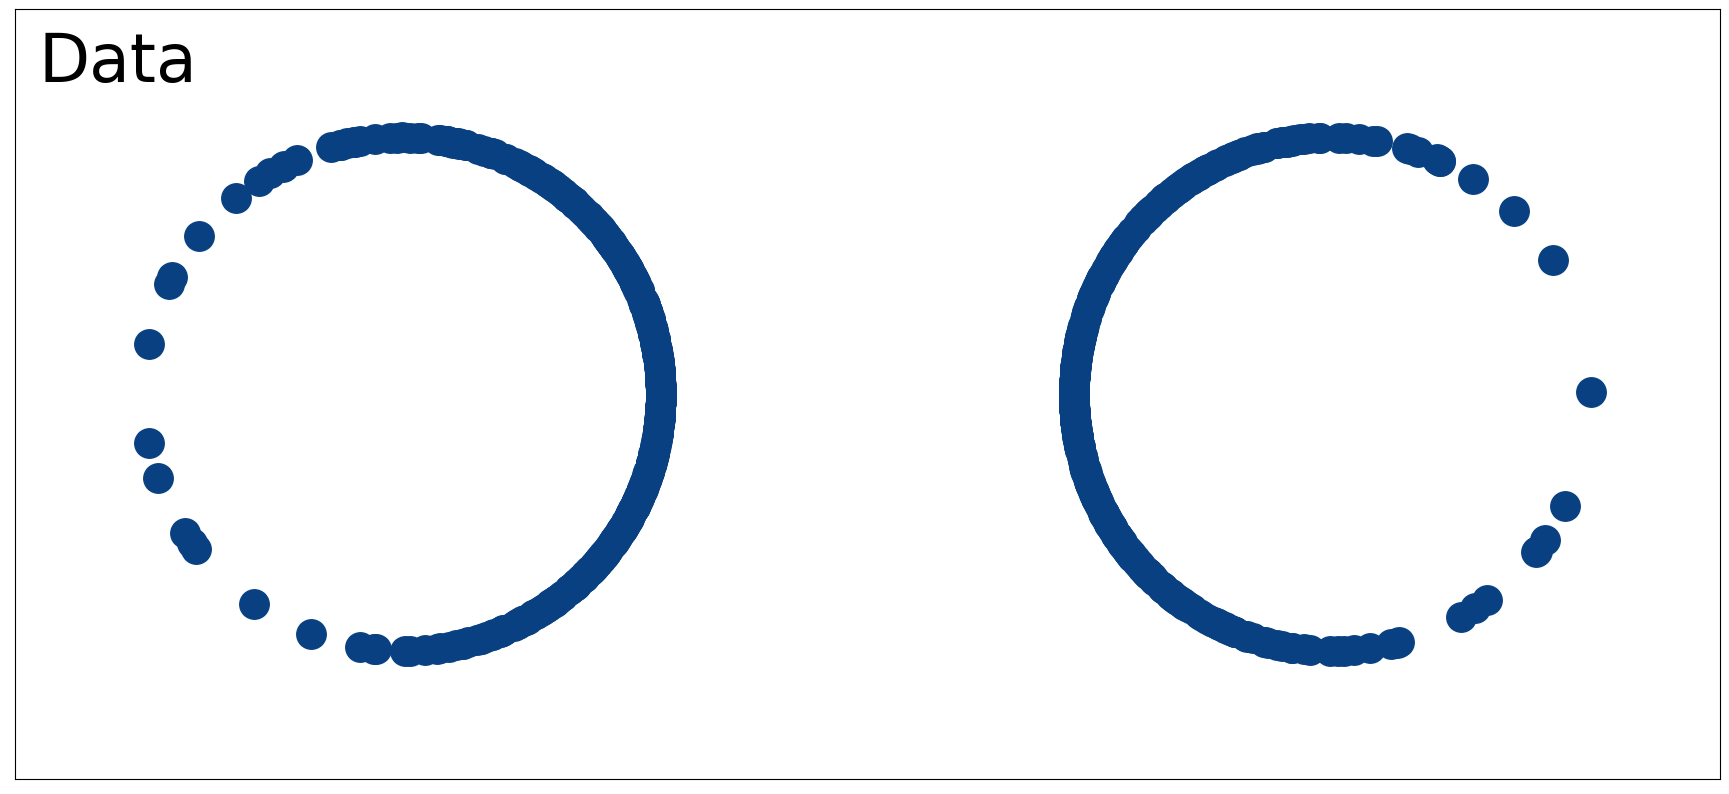

In [4]:
fig = plt.figure(figsize=(22, 10))
plot_2d_points(data, text="Data", text_x=-3.21, text_y=1.22, fontsize=48, ax=fig.add_subplot(), s=450, **lims)

## EBIM

Initialize and optimize a manifold-defining function (MDF).

In [5]:
%%time
from torch import optim
from implicit.maps import FlatSmoothMap
from implicit.models.ebm import ImplicitManifold

mdf = FlatSmoothMap(2, 1, hidden_size=8, spectral_norm=False)
manifold = ImplicitManifold(mdf, ebm_lims, device)

opt = optim.Adam(mdf.parameters(), lr=0.01)

manifold.train(
    optim=opt,
    dataloader=dataloader,
    epochs=500,
    neg_weight=0.3,
    mu=1.,
    sv_min=1.,
    buffer_frac=0.95,
    mc_kwargs={
        "eps": 0.1,
        "alpha": 10,
    },
    callbacks=callbacks,
)

[E500] loss: -0.0107 | pos: 0.0043 | neg: 0.1062 | sv_min: 0.0001 | sv_max: 0.0000 | scale: 0.0169: 100%|███████████| 500/500 [03:37<00:00,  2.30it/s]

CPU times: user 3min 37s, sys: 3.12 s, total: 3min 40s
Wall time: 3min 37s


In [6]:
from implicit.metrics import distance_to_implicit_manifold

implicit_dists = distance_to_implicit_manifold(data, manifold, opt_steps=100)
implicit_dists.min(), implicit_dists.median(), implicit_dists.mean(), implicit_dists.max()

(tensor(3.3691e-05), tensor(0.0037), tensor(0.0045), tensor(0.0380))

The zeros of the MDF should now represent the ground truth manifold

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


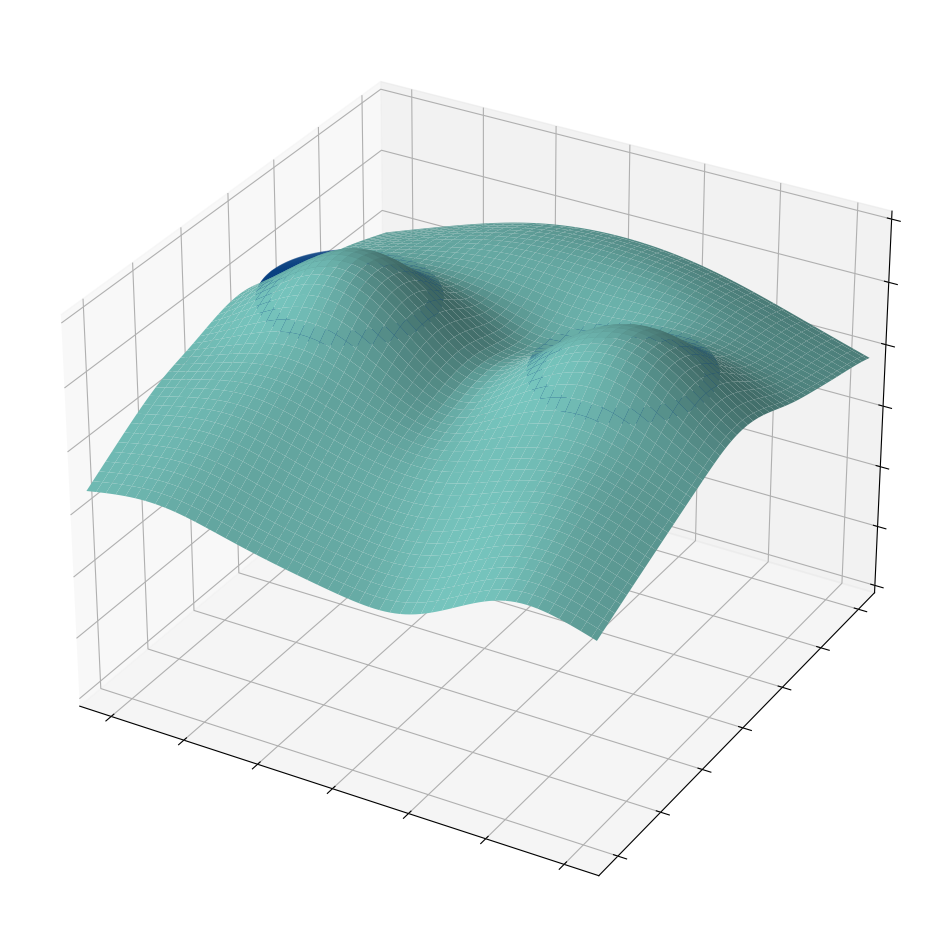

In [7]:
from visualization import plot_2d_to_1d_func, COLOURS

plot_2d_to_1d_func(mdf, points, s=100, **lims3d, zlims=(-5, 1))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


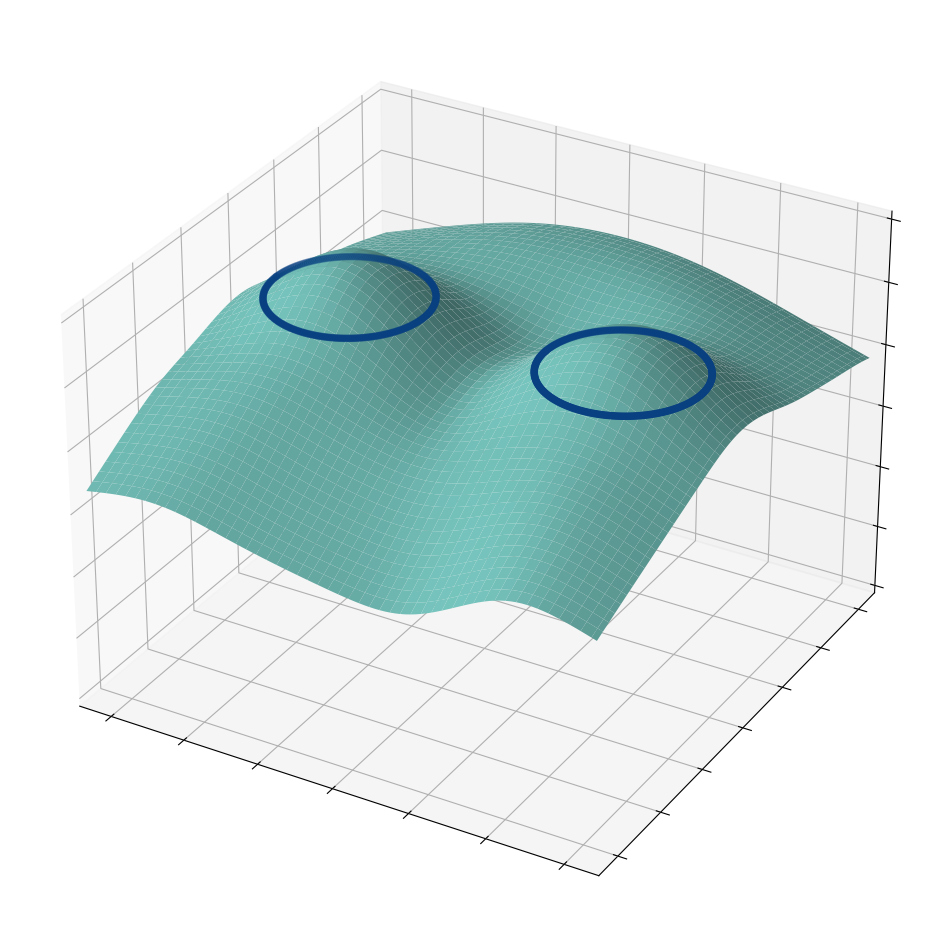

In [8]:
from visualization import plot_2d_to_1d_func, COLOURS

plot_2d_to_1d_func(mdf, points, computed_zorder=False, **lims3d, zlims=(-5, 1))

Initialize and train a constrained EBM with the above manifold

In [9]:
%%time
from implicit.models.ebm import ConstrainedEBM

ambient_energy = FlatSmoothMap(2, 1, num_layers=2, spectral_norm=False)
cebm = ConstrainedEBM(manifold, ambient_energy, lims=ebm_lims, device=device, 
                     line_search_fn="strong_wolfe")

opt = optim.Adam(ambient_energy.parameters(), lr=0.01)

cebm.train(
    optim=opt,
    dataloader=dataloader, 
    epochs=10,
    beta=0.3,
    clip_norm=1.,
    buffer_frac=0.95,
    noise_kwargs={
        "opt_steps": 1,
        "line_search_fn": "strong_wolfe",
    },
    mc_kwargs={
        "n_steps": 10,
        "eps": 0.5,
        "alpha": 1,
        "grad_clamp": 0.1,
        "opt_steps": 1,
        "line_search_fn": "strong_wolfe",
    },
    callbacks=callbacks,
)

[E 10] loss: -0.3533 | scale_loss: 1.0985: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.62s/it]

CPU times: user 2min 37s, sys: 165 ms, total: 2min 37s
Wall time: 1min 21s


Plot resulting energy in ambient space

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


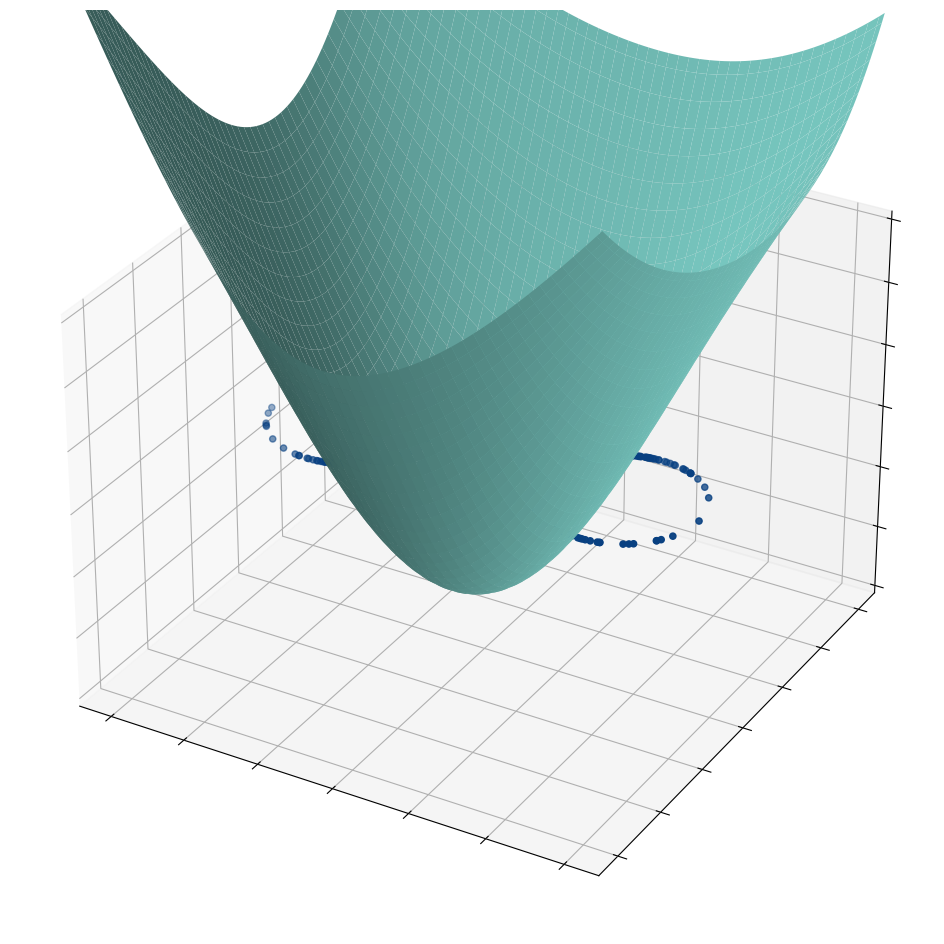

In [10]:
plot_2d_to_1d_func(ambient_energy.cpu(), points2d=data, **lims3d)

Plot learned density

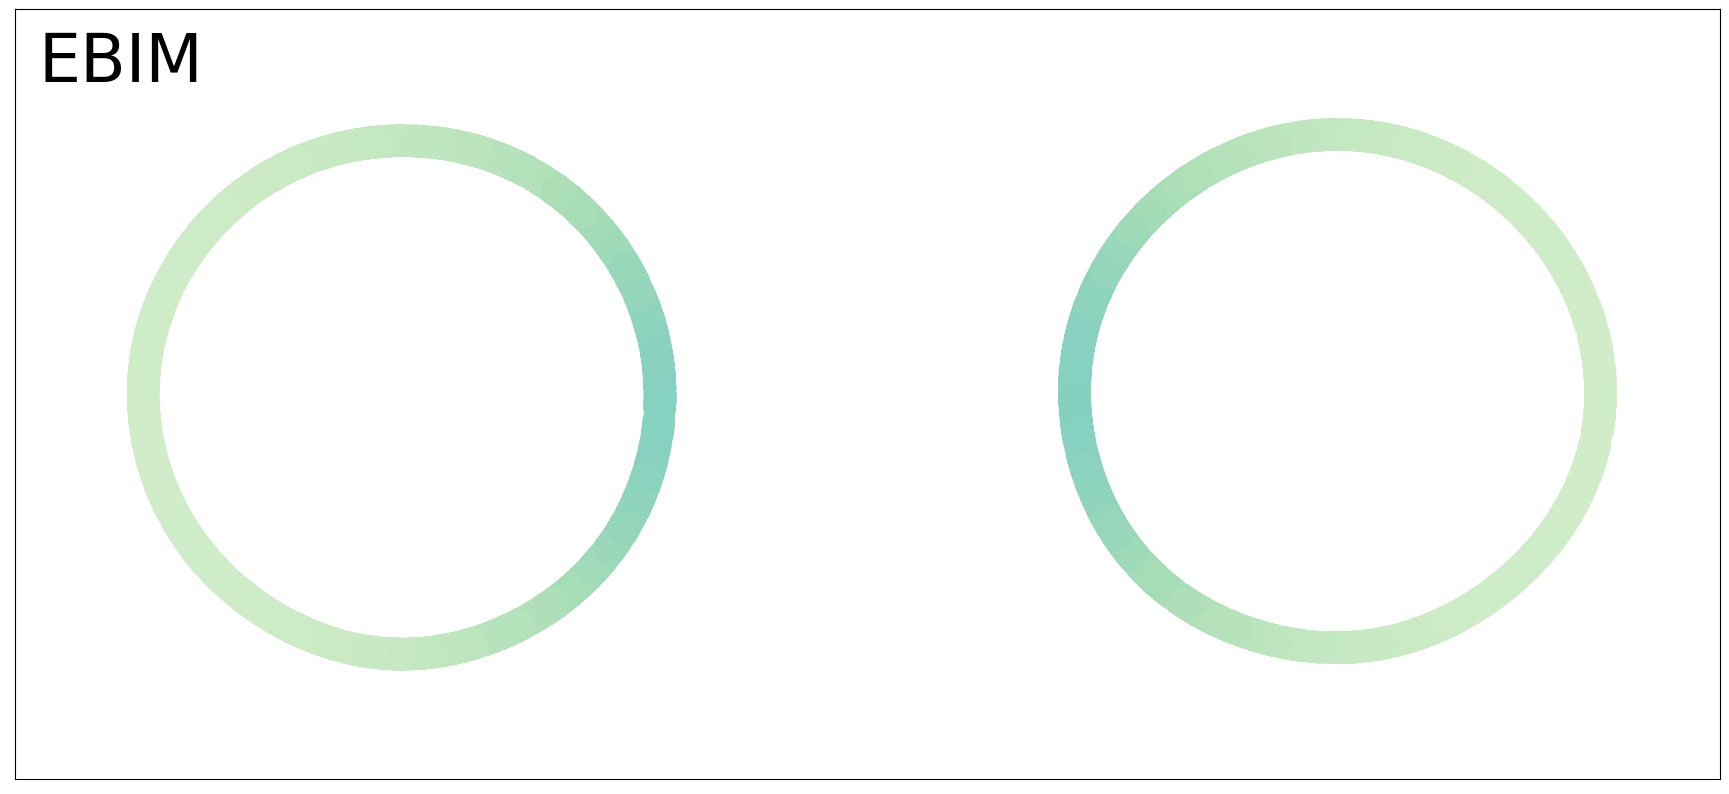

In [11]:
learned_points = cebm.sample_noise(4000)

with torch.no_grad():
    densities_unnorm = torch.exp(-ambient_energy(learned_points)).squeeze()
    partition = torch.mean(densities_unnorm) * (4 * np.pi)
    densities = densities_unnorm / partition
    

fig = plt.figure(figsize=(22, 10))
plot_2d_points(learned_points, text="EBIM", text_x=-3.21, text_y=1.22, fontsize=48,
               darken=0.2, c=densities, s=500, ax=fig.add_subplot(), **lims)

In [12]:
from implicit.metrics import wasserstein_between_discretized_densities

gt_points = torch.cat(dist.manifold_points())
gt_densities = dist.prob(gt_points)

wasserstein_between_discretized_densities(
    learned_points,
    densities,
    gt_points,
    gt_densities,
    ebm_lims.T.numpy(),
)

0.0016739575216457396

# EBM

Define energy function and train

In [13]:
%%time
from implicit.models.ebm import EBM

energy = FlatSmoothMap(2, 1, num_layers=3)
ebm = EBM(energy, lims=ebm_lims, device=device, buffer_size=1000)
opt = optim.Adam(energy.parameters(), lr=0.01)


ebm.train(
    # Optimization args
    optim=opt,
    dataloader=dataloader, 
    epochs=200, 
    beta=0.5,
    clip_norm=1.,

    # Sampling args
    buffer_frac=0.95,
    mc_kwargs={
        "n_steps": 20,
        "eps": 0.1,
        "alpha": 10,
        "grad_clamp": 0.03,
    },
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:16<00:00,  2.62it/s]

CPU times: user 1min 16s, sys: 275 ms, total: 1min 16s
Wall time: 1min 16s


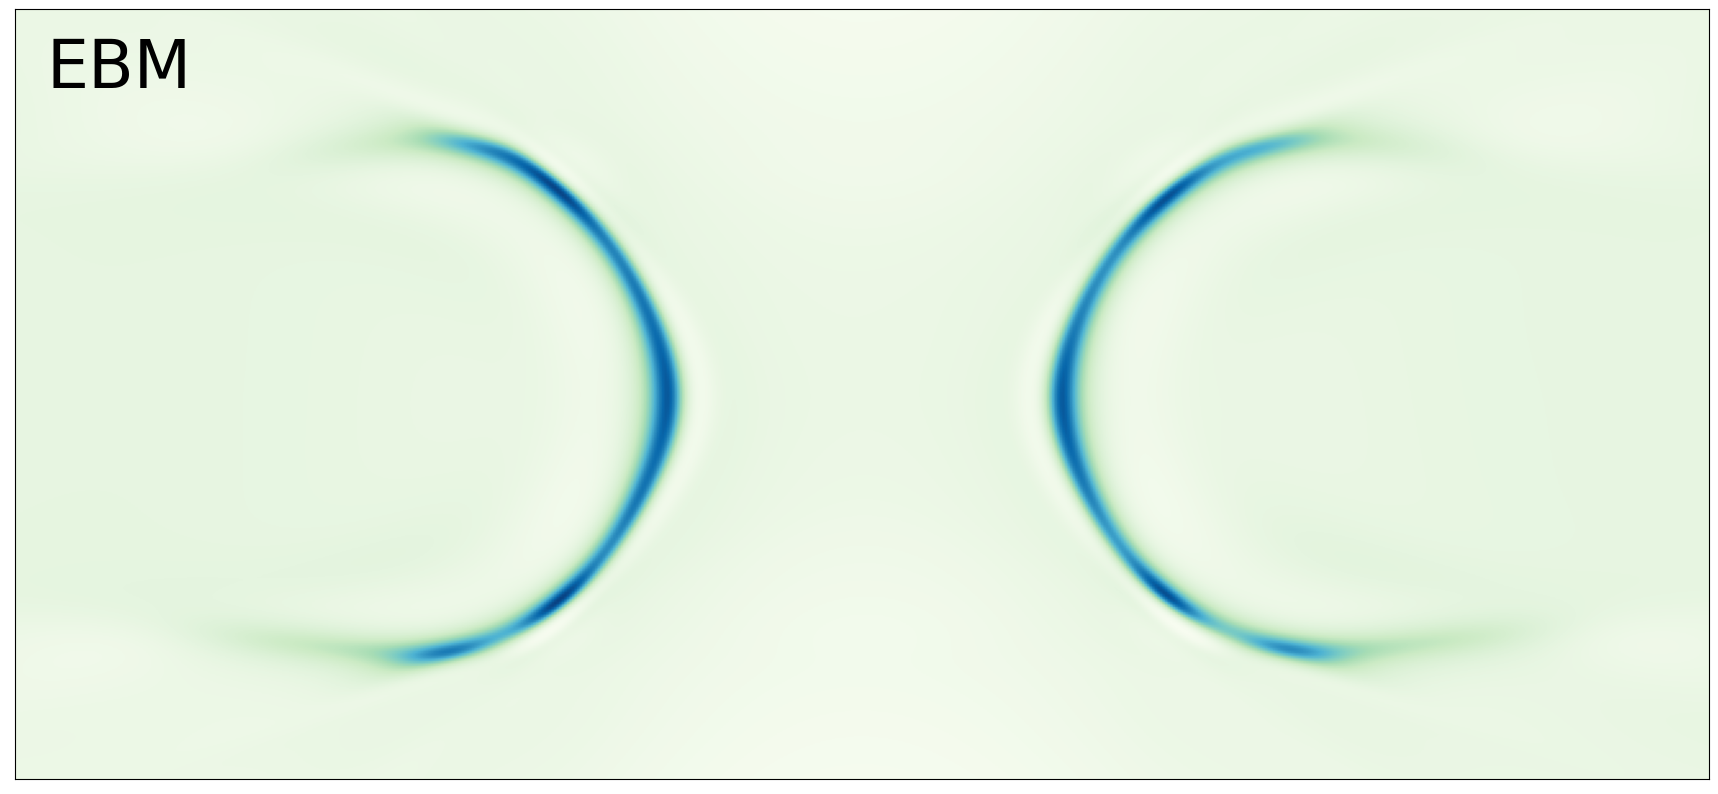

In [14]:
from visualization import plot_func_heatmap

with torch.no_grad():
    uniform_noise = ebm.sample_noise(1000)
    unnorm_probs = torch.exp(-energy(uniform_noise))
    latent_volume = torch.prod(ebm.lims[1] - ebm.lims[0])
    partition = torch.mean(unnorm_probs) * latent_volume
    
density_func = lambda x: torch.exp(-energy(x)).detach() / partition

fig = plt.figure(figsize=(22, 10))
plot_func_heatmap(density_func, text="EBM", ax=fig.add_subplot(), fontsize=48, **lims)

# Pushforward EBM

Initialize and train an autoencoder with latent EBM

In [15]:
%%time
from itertools import chain
from implicit.models.ebm import PushforwardEBM
from implicit.models.autoencoder import Autoencoder

encoder = FlatSmoothMap(2, 1)
decoder = FlatSmoothMap(1, 2)
latent_energy = FlatSmoothMap(1, 1)

ae = Autoencoder(encoder, decoder, device=device)
ae_ebm = PushforwardEBM(ae, latent_energy, device=device, buffer_size=1000)

ae_ebm.train_ae(
    optim=optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=0.001),
    dataloader=data.split(100), 
    epochs=1000,
    clip_norm=1.
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 31.23it/s]

CPU times: user 32.1 s, sys: 103 ms, total: 32.2 s
Wall time: 32 s


In [16]:
from implicit.metrics import distance_to_pushforward_manifold

ae_dists = distance_to_pushforward_manifold(data, ae_ebm.autoencoder)
ae_dists.min(), ae_dists.median(), ae_dists.mean(), ae_dists.max()

(tensor(8.1012e-06), tensor(0.0047), tensor(0.0051), tensor(0.0948))

In [17]:
%%time

ae_ebm.train_ebm(
    optim=optim.Adam(latent_energy.parameters(), lr=0.01),
    dataloader=dataloader, 
    epochs=300, 
    beta=0.1,
    clip_norm=1.,  
    buffer_frac=0.95,  
    mc_kwargs={
        "n_steps": 20,
        "eps": 1,
        "alpha": 10,
    },
    callbacks=callbacks,
)

[E300] loss: -2.7610 | scale_loss: 28.9135: 100%|███████████████████████████████████████████████████████████████████| 300/300 [02:31<00:00,  1.98it/s]

CPU times: user 50min 28s, sys: 1.39 s, total: 50min 29s
Wall time: 2min 31s


Plot learned density

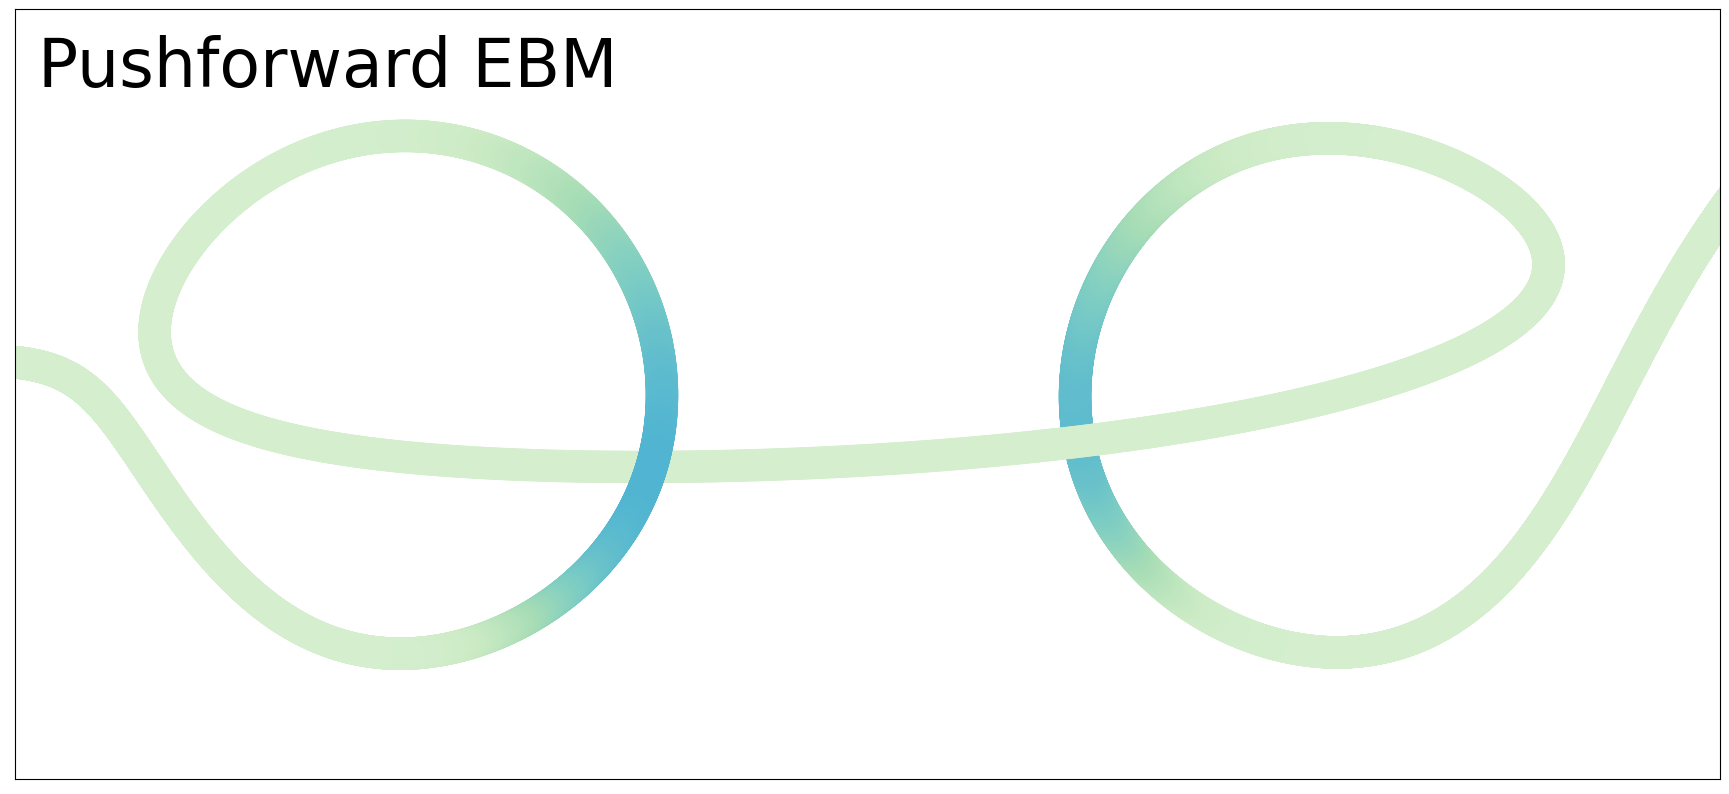

In [18]:
with torch.no_grad():
    lower, upper = ae_ebm.ebm.lims
    lattice = torch.linspace(lower[0].tolist(), upper[0].tolist(), 10000)[:, None]

    densities = ae_ebm.prob(z=lattice).squeeze()
    points = ae_ebm.decoder(lattice)
    
fig = plt.figure(figsize=(22, 10))
plot_2d_points(points, text="Pushforward EBM", text_x=-3.21, text_y=1.2, fontsize=48,
               darken=0.2, c=densities, s=500, ax=fig.add_subplot(), **lims)

In [19]:
wasserstein_between_discretized_densities(
    learned_points,
    densities,
    gt_points,
    gt_densities,
    ebm_lims.T.numpy(),
)

0.012130463924867574